<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-DATE-a-datetime" data-toc-modified-id="Conversión-de-la-columna-DATE-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna DATE a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARIMA" data-toc-modified-id="Modelo-ARIMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARIMA</a></span></li></ul></div>

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")

# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [2]:
df = pd.read_csv("data/caramelos.csv", index_col = 0)
df.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG3113N,564.0,101.136666,18.131158,50.680157,88.344728,102.777853,114.928399,139.302096


## Conversión de la columna DATE a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.dtypes

date         object
IPG3113N    float64
dtype: object

In [5]:
# colocamos la columna a datetime y la ponemos como índice
df.index = pd.to_datetime(df["date"])
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [6]:
# veamos como es nuestro índice
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq=None)

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [7]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq='MS')

Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

In [8]:
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [9]:
# por último eliminamos la columna de DATE que ya no nos hace falta. 
df.drop(columns=['date'], inplace=True)
df.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

In [10]:
df.isnull().sum()

IPG3113N    0
dtype: int64

In [11]:
df.isnull().sum()

IPG3113N    0
dtype: int64

In [12]:
df.columns = ["valores"]

# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendendia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

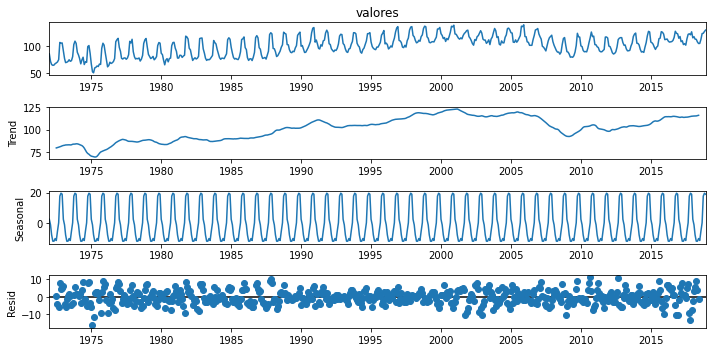

In [13]:
res = seasonal_decompose(df.valores, model="additive")
res.plot();

## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [14]:
df.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [16]:
df["year"] = df.index.year
df["month"] = df.index.month
df.head()

,valores,year,month
date,,,
1972-01-01,85.598809,1972,1
1972-02-01,71.741404,1972,2
1972-03-01,65.948809,1972,3
1972-04-01,64.490724,1972,4
1972-05-01,64.933842,1972,5


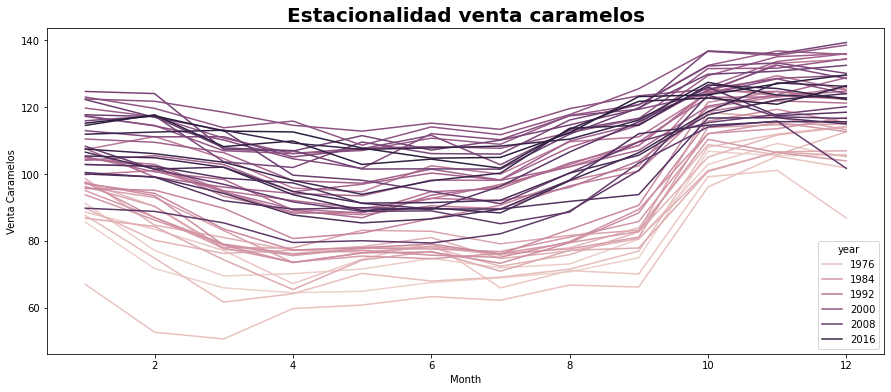

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(df['month'], df['valores'], hue=df['year'])
ax.set_title('Estacionalidad venta caramelos', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month')
ax.set_ylabel('Venta Caramelos');



## Estacionaridad

Se puede decir que una serie es estacionaria cuando **su media y su varianza no están en función del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayoría de los métodos estadísticos para realizar análisis y predicciones se basan en la suposición de que las propiedades estadísticas de la serie (media, varianza, correlación, etc.) son constantes en el tiempo.

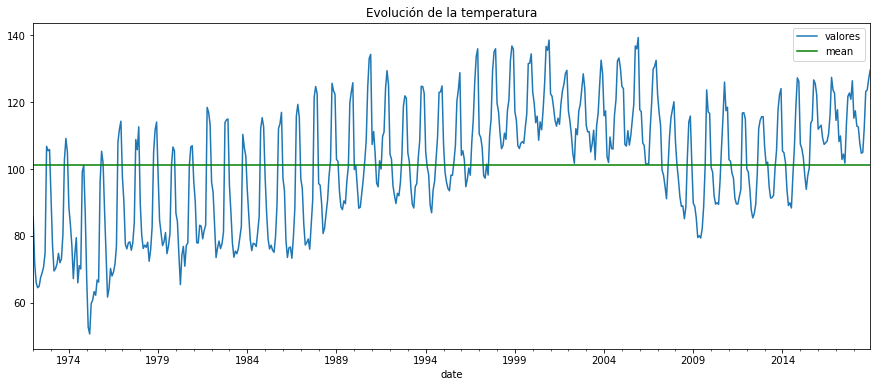

In [28]:
df.plot(figsize=(15,6))
plt.title("Evolución de la temperatura")
plt.axhline(df.valores.mean(), c="g", label="mean")
plt.legend();


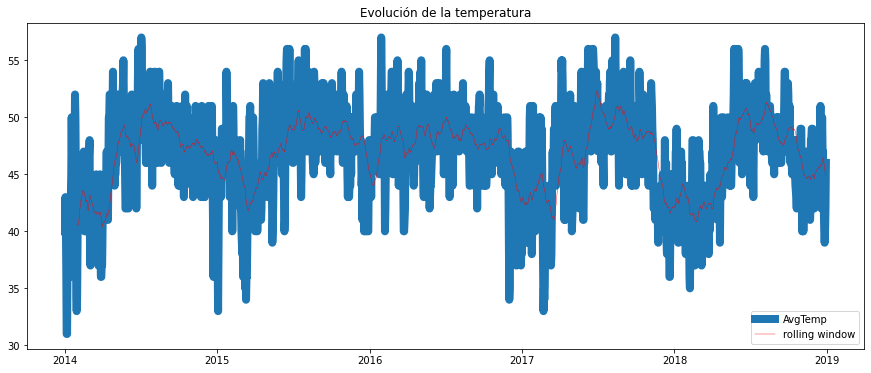

In [15]:
plt.figure(figsize=(15,6))
plt.title("Evolución de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8)
plt.plot(df.rolling(window =30).mean(), label="rolling window", c= "r", linewidth = 0.4)

plt.legend();

Al plotear la media junto con los puntos de datos originales, podemos ver que son  algo constantes en el tiempo, no vemos ninguna tendencia de incremento o disminución. Sin embargo, parecen seguir un comportamiento. cíclico. Pero esto nos puede convencer poco, también podemos hacer el test de ADFuller

In [29]:
res_ad = adfuller(df["valores"])
res_ad

(-1.7760153075016094,
 0.39243275007140066,
 14,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3094.828881317046)

In [30]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
	print( "\t",  key, round(value, 2))

ADF Statistic: -1.7760153075016094
p-value: 0.39243275007140066
Critical Values:
	 1% -3.44
	 5% -2.87
	 10% -2.57


**¿Cuáles son las conclusiones de esta prueba?**

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS


- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS

## Comparativa estacionalidad vs estacionaridad

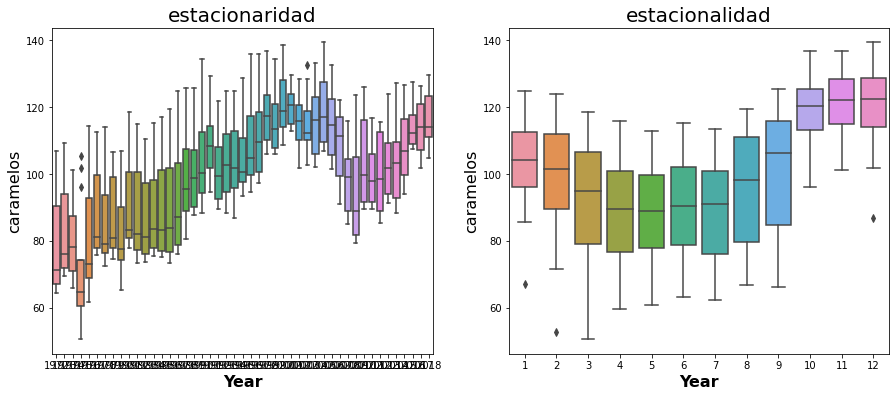

In [37]:
# nos creamos una lista con las columnas de tiempo
tiempo = df.columns.drop("valores")

componentes = ["Estacionaridad", "Estacionalidad"]

#iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# hacemos nuestro for para no repetir lineas de código
for i, col in enumerate(tiempo):
    sns.boxplot(df[col], df["valores"], ax=ax[i])
    ax[i].set_title(componentes[i], fontsize = 20, loc='center')
    ax[i].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('caramelos', fontsize = 16)
plt.show()

# Autocorrelación

- `Auto-correlación`: la correlación entre dos series de tiempo.


- `Auto-correlación parcial`: es una medida de la correlación entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), después de ajustarse para la presencia de los demás términos de desfase más corto (yt-1, yt-2, ..., yt–k–1).

METER IMAGEN

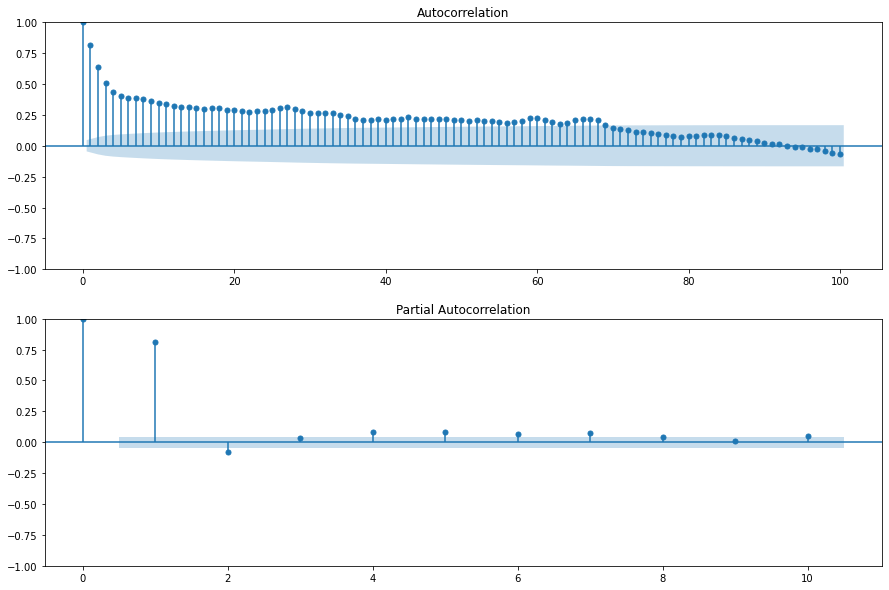

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=100, ax= axes[0])
plot_pacf(df, lags=10, ax= axes[1]);



# Modelo ARIMA

Para hacer predicciones necesitaremos usar los modelos ARMA o ARIMA. ¿Qué signfican estos conceptos? 

Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [19]:
y_test = df["valores"][-30:]
y_train = df["valores"][:-30]

In [20]:
ps = range(9)
qs = range(70,80)

parameters = list(product(ps, qs))
print(parameters)

[(0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (1, 70), (1, 71), (1, 72), (1, 73), (1, 74), (1, 75), (1, 76), (1, 77), (1, 78), (1, 79), (2, 70), (2, 71), (2, 72), (2, 73), (2, 74), (2, 75), (2, 76), (2, 77), (2, 78), (2, 79), (3, 70), (3, 71), (3, 72), (3, 73), (3, 74), (3, 75), (3, 76), (3, 77), (3, 78), (3, 79), (4, 70), (4, 71), (4, 72), (4, 73), (4, 74), (4, 75), (4, 76), (4, 77), (4, 78), (4, 79), (5, 70), (5, 71), (5, 72), (5, 73), (5, 74), (5, 75), (5, 76), (5, 77), (5, 78), (5, 79), (6, 70), (6, 71), (6, 72), (6, 73), (6, 74), (6, 75), (6, 76), (6, 77), (6, 78), (6, 79), (7, 70), (7, 71), (7, 72), (7, 73), (7, 74), (7, 75), (7, 76), (7, 77), (7, 78), (7, 79), (8, 70), (8, 71), (8, 72), (8, 73), (8, 74), (8, 75), (8, 76), (8, 77), (8, 78), (8, 79)]


In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
%%time
rmse = []
order = []
for p, q in parameters:
    try:
        modelo=ARIMA(y_train, order=(p, 0, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,q))
    except: 
        continue



In [ ]:
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)

In [ ]:
results.head()

,RMSE,order


In [ ]:
modelo=ARIMA(y_train, order=(4, 1, 5)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [ ]:
fecha = pd.date_range("2016-07-01  ", periods=30, freq="MS")

In [ ]:
pred.index = fecha

In [ ]:
pred.head()

,predicted_mean
2016-07-01,105.685871
2016-08-01,114.340048
2016-09-01,119.194656
2016-10-01,127.219321
2016-11-01,127.824141


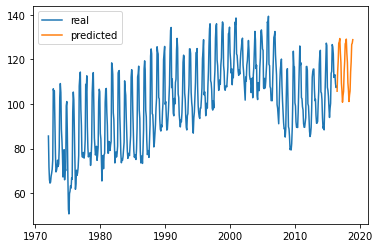

In [ ]:
plt.plot(y_train)
plt.plot(pred)
plt.legend(["real", "predicted"]);

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
datos : https://github.com/nachi-hebbar/ARIMA-Temperature_Forecasting/blob/master/MaunaLoaDailyTemps.csv

In [ ]:
pred["real"] = y_test

In [ ]:
pred.head()

,predicted_mean,real
2016-07-01,105.685871,108.329463
2016-08-01,114.340048,110.411130
2016-09-01,119.194656,116.116339
2016-10-01,127.219321,127.385243
2016-11-01,127.824141,123.605806


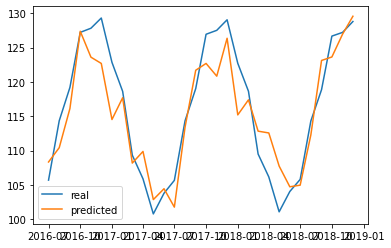

In [ ]:
plt.plot(pred['predicted_mean'])
plt.plot(pred["real"])
plt.legend(["real", "predicted"]);

In [ ]:
y_test

date
2016-07-01    108.329463
2016-08-01    110.411130
2016-09-01    116.116339
2016-10-01    127.385243
2016-11-01    123.605806
2016-12-01    122.692205
2017-01-01    114.517938
2017-02-01    117.693169
2017-03-01    108.170772
2017-04-01    109.863949
2017-05-01    102.847162
2017-06-01    104.430882
2017-07-01    101.751101
2017-08-01    113.390618
2017-09-01    121.700707
2017-10-01    122.693104
2017-11-01    120.838739
2017-12-01    126.362886
2018-01-01    115.193151
2018-02-01    117.385772
2018-03-01    112.821765
2018-04-01    112.560408
2018-05-01    107.733546
2018-06-01    104.714210
2018-07-01    104.950500
2018-08-01    112.279777
2018-09-01    123.126335
2018-10-01    123.634268
2018-11-01    126.960101
2018-12-01    129.571073
Freq: MS, Name: valores, dtype: float64

In [ ]:
fecha2 = pd.date_range("2019-01-01  ", periods=12, freq="MS")
fecha2

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
pred2 = pd.DataFrame(modelo.predict(start=len(df) , end=len(df)  + 12))

In [ ]:
pred2

,predicted_mean
2019-01-01,122.572188
2019-02-01,118.650578
2019-03-01,109.646615
2019-04-01,106.412477
2019-05-01,101.362263
2019-06-01,104.279470
2019-07-01,105.928028
2019-08-01,114.299632
2019-09-01,118.706827
2019-10-01,126.413719


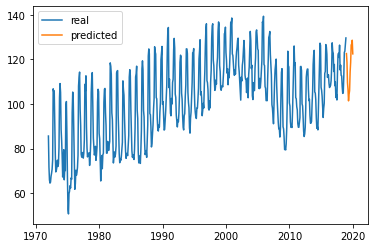

In [ ]:
plt.plot(df)
plt.plot(pred2)
plt.legend(["real", "predicted"]);

In [ ]:
df.head()

,valores
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [ ]:
df2 = df[df.index.year > 2017]
df2.head()

,valores
date,
2018-01-01,115.193151
2018-02-01,117.385772
2018-03-01,112.821765
2018-04-01,112.560408
2018-05-01,107.733546


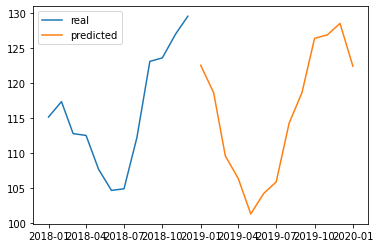

In [ ]:
plt.plot(df2)
plt.plot(pred2)
plt.legend(["real", "predicted"]);